In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
torch.cuda.is_available()
device = torch.device("cuda")
np.random.seed(42)
torch.manual_seed(42)

In [3]:
data = pd.read_csv('final_data.csv')

In [4]:
data

,subject_id,time_window,heart_rate_mean,heart_rate_max,heart_rate_min,heart_rate_median,systolic_bp_mean,systolic_bp_max,systolic_bp_min,systolic_bp_median,...,respiratory_rate_max,respiratory_rate_min,respiratory_rate_median,oxygen_saturation_mean,oxygen_saturation_max,oxygen_saturation_min,oxygen_saturation_median,mortality_24h,age_years,gender
0,34,"(24.0, 48.0]",65.307692,86.0,55,60.0,118.923077,124.0,111,121.0,...,21,14,19.0,96.153846,98,92,97.0,0,300.201914,M
1,34,"(0.0, 24.0]",62.228571,86.0,43,56.0,126.285714,169.0,107,117.0,...,26,9,19.0,96.685714,100,75,98.0,0,300.201914,M
2,85,"(24.0, 48.0]",106.583333,123.0,86,110.0,118.125000,142.0,85,120.5,...,36,20,26.0,96.083333,98,90,96.0,0,71.500236,M
3,85,"(0.0, 24.0]",98.781250,132.0,79,97.5,106.343750,166.0,73,108.0,...,36,20,27.0,98.218750,100,96,98.0,0,71.500236,M
4,109,"(10656.0, 10680.0]",97.500000,99.0,96,97.5,130.000000,138.0,122,130.0,...,30,28,29.0,95.500000,99,92,95.5,0,24.540947,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39049,99982,"(24.0, 48.0]",89.302326,100.0,84,88.0,109.837209,113.0,94,113.0,...,30,0,15.0,98.302326,100,94,99.0,0,65.201362,M
39050,99982,"(0.0, 24.0]",79.192308,89.0,70,79.5,105.769231,113.0,73,113.0,...,21,5,16.5,98.269231,100,95,98.0,0,65.201362,M
39051,99995,"(48.0, 72.0]",79.500000,81.0,78,79.5,116.500000,120.0,113,116.5,...,21,20,20.5,98.000000,98,98,98.0,0,88.757078,F
39052,99995,"(24.0, 48.0]",78.333333,86.0,69,77.0,115.037037,136.0,113,113.0,...,25,11,21.0,97.407407,100,95,98.0,0,88.757078,F


In [5]:
# Age outliers clean
median_age = data.loc[data['age_years'] <= 100, 'age_years'].median()
data.loc[data['age_years'] > 100, 'age_years'] = median_age

# One-hot to sex
gender_one_hot = pd.get_dummies(data['gender'], prefix='gender')
data = pd.concat([data, gender_one_hot], axis=1)
data.drop('gender', axis=1, inplace=True)


In [6]:
data.head()

,subject_id,time_window,heart_rate_mean,heart_rate_max,heart_rate_min,heart_rate_median,systolic_bp_mean,systolic_bp_max,systolic_bp_min,systolic_bp_median,...,respiratory_rate_min,respiratory_rate_median,oxygen_saturation_mean,oxygen_saturation_max,oxygen_saturation_min,oxygen_saturation_median,mortality_24h,age_years,gender_F,gender_M
0,34,"(24.0, 48.0]",65.307692,86.0,55,60.0,118.923077,124.0,111,121.0,...,14,19.0,96.153846,98,92,97.0,0,69.207974,False,True
1,34,"(0.0, 24.0]",62.228571,86.0,43,56.0,126.285714,169.0,107,117.0,...,9,19.0,96.685714,100,75,98.0,0,69.207974,False,True
2,85,"(24.0, 48.0]",106.583333,123.0,86,110.0,118.125000,142.0,85,120.5,...,20,26.0,96.083333,98,90,96.0,0,71.500236,False,True
3,85,"(0.0, 24.0]",98.781250,132.0,79,97.5,106.343750,166.0,73,108.0,...,20,27.0,98.218750,100,96,98.0,0,71.500236,False,True
4,109,"(10656.0, 10680.0]",97.500000,99.0,96,97.5,130.000000,138.0,122,130.0,...,28,29.0,95.500000,99,92,95.5,0,24.540947,True,False


In [7]:
# First, we convert the 'time_window' column to a numeric format by taking the end of the interval
# data['time_window_end'] = data['time_window'].str.extract(r'\, (\d+\.?\d*)\]').astype(float)

data['time_window_numeric'] = data['time_window'].str.extract(r'\, (\d+\.?\d*)\]').astype(float)

# Now we can drop the original 'time_window' column
data = data.drop('time_window', axis=1)

# Next, we separate the features and labels
features = data.drop(['mortality_24h'], axis=1)
labels = data['mortality_24h'].values.reshape(-1, 1)

# Normalize the features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Convert the normalized features and labels into PyTorch tensors
features_tensor = torch.tensor(features_normalized, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.2, random_state=42)

# Pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  

In [9]:
# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # bi-directional
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=x.device) 
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()



In [10]:
def cross_validate(model, criterion, optimizer, X, y, epochs=20, k=5, patience=3):
    device = next(model.parameters()).device  
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X.numpy())):
        best_val_loss = float('inf')
        patience_counter = 0
                
        X_train = torch.tensor(X[train_idx].numpy(), device=device, dtype=torch.float32)
        y_train = torch.tensor(y[train_idx].numpy(), device=device, dtype=torch.float32)
        X_val = torch.tensor(X[val_idx].numpy(), device=device, dtype=torch.float32)
        y_val = torch.tensor(y[val_idx].numpy(), device=device, dtype=torch.float32)
        
        model.to(device)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train.unsqueeze(1))
            loss = criterion(output, y_train.squeeze())  
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_output = model(X_val.unsqueeze(1))
                val_loss = criterion(val_output, y_val.squeeze())  
            
            print(f"Fold {fold}, Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping triggered at fold {fold}, epoch {epoch}.")
                break

In [11]:
input_size = features_tensor.shape[1]  

hidden_size = 128  
num_layers = 3  
output_size = 1  

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

pos_weight = torch.tensor([38633/421], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

cross_validate(model, criterion, optimizer, features_tensor, labels_tensor, epochs=20, k=5, patience=3)


C:\Users\ALIENWARE\miniconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 0, Epoch 0, Training Loss: 1.3831056356430054, Validation Loss: 1.3284006118774414
Fold 0, Epoch 1, Training Loss: 1.382739782333374, Validation Loss: 1.328401803970337
Fold 0, Epoch 2, Training Loss: 1.3818600177764893, Validation Loss: 1.3284494876861572
Fold 0, Epoch 3, Training Loss: 1.3816920518875122, Validation Loss: 1.3285108804702759
Early stopping triggered at fold 0, epoch 3.
Fold 1, Epoch 0, Training Loss: 1.3816064596176147, Validation Loss: 1.3284626007080078
Fold 1, Epoch 1, Training Loss: 1.3810194730758667, Validation Loss: 1.3284629583358765
Fold 1, Epoch 2, Training Loss: 1.3808122873306274, Validation Loss: 1.3283957242965698
Fold 1, Epoch 3, Training Loss: 1.3806335926055908, Validation Loss: 1.328233242034912
Fold 1, Epoch 4, Training Loss: 1.379888892173767, Validation Loss: 1.32794988155365
Fold 1, Epoch 5, Training Loss: 1.379072904586792, Validation Loss: 1.3275216817855835
Fold 1, Epoch 6, Training Loss: 1.378840446472168, Validation Loss: 1.326919436454

Accuracy: 0.9045
AUC: 0.8308


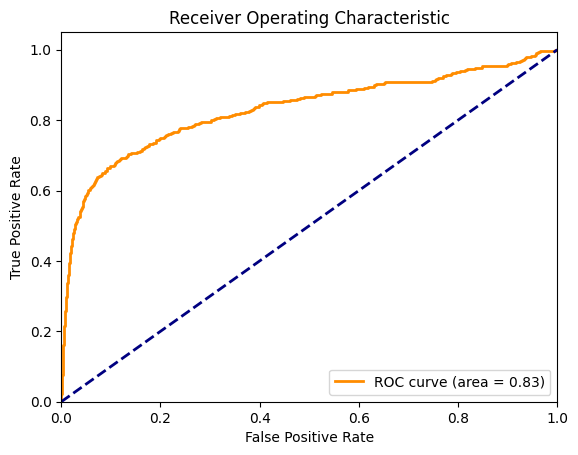

In [13]:
def evaluate_model(model, features_tensor, labels_tensor):
    model.eval()  
    with torch.no_grad():  
        logits = model(features_tensor.unsqueeze(1).to(device))  
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  
    true_labels = labels_tensor.cpu().numpy()  
    pred_labels = (probs > 0.5).astype(int)  

    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc_score:.4f}')

    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

model.to(device) 
evaluate_model(model, features_tensor, labels_tensor)

Accuracy: 0.9045
AUROC: 0.8308
AUPRC: 0.1533


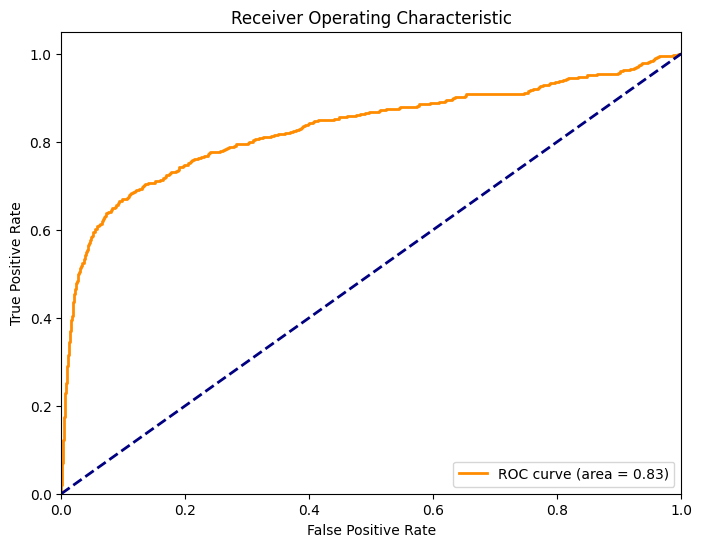

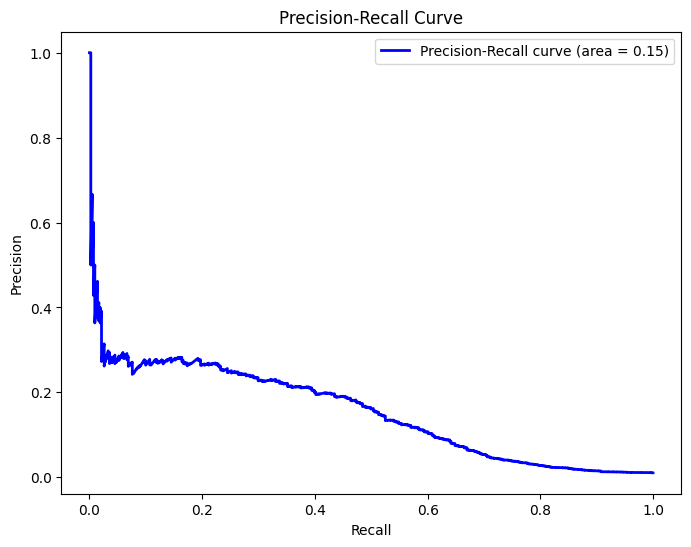

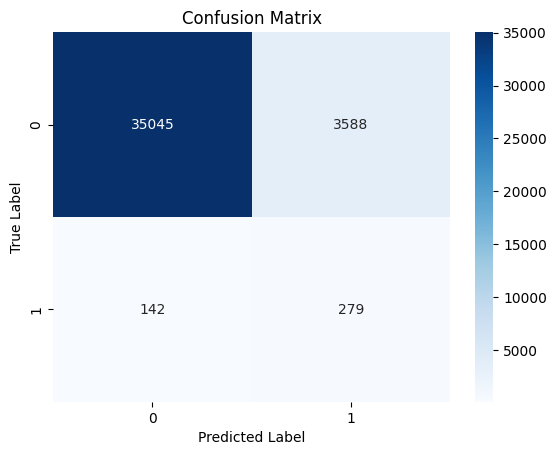

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, features_tensor, labels_tensor, device):
    model.eval() 
    with torch.no_grad(): 
        logits = model(features_tensor.unsqueeze(1).to(device))  
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  
    true_labels = labels_tensor.cpu().numpy()  
    pred_labels = (probs > 0.5).astype(int) 
 
   
    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    pr_auc = auc(recall, precision)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUROC: {auc_score:.4f}')
    print(f'AUPRC: {pr_auc:.4f}')
    
    # ROC
    fpr, tpr, _ = roc_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # PRC
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
evaluate_model(model, features_tensor, labels_tensor, device)


In [15]:
def evaluate_model(model, features_tensor, labels_tensor, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Do not compute gradient
        logits = model(features_tensor.unsqueeze(1).to(device))  # Ensure input dimension and device are correct
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()  # Apply sigmoid and convert to numpy array
    true_labels = labels_tensor.cpu().numpy()  # Convert true labels to numpy array
    pred_labels = (probs > 0.5).astype(int)  # Generate predicted labels based on probability

    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    auc_score = roc_auc_score(true_labels, probs)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUROC: {auc_score:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')



In [16]:
evaluate_model(model, features_tensor, labels_tensor, device)


Accuracy: 0.9045
AUROC: 0.8308
Precision: 0.0721
Recall: 0.6627
F1 Score: 0.1301
